In [1]:
import os
print("Current working directory:", os.getcwd()) 
os.chdir("C:/Users/mgabi/Desktop/immo-eliza-ml")    ############ specify your working directory ############

Current working directory: c:\Users\mgabi\Desktop\immo-eliza-ml\Notebooks


In [2]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Defining the functions for preprocessing and creating the Heatmaps

In [ ]:


# Variables to be used in the process of processing and running the models
parameters = [
    'construction_year', 'total_area_sqm', 'nbr_frontages', 'nbr_bedrooms', 'kitchen_type_encoded',
    'Bulding_sta_encoded', 'epc_encoded', 'garden_sqm', 'surface_land_sqm', "fl_double_glazing", 'fl_terrace',
    'fl_swimming_pool', 'fl_floodzone', 'latitude', 'longitude', 'zip_code'
] #+ list(locality_encoded_df.columns)  the locality parameter is called later in the function. 
Heat_map_parmeters = [
    'price', 'construction_year', 'total_area_sqm', 'nbr_frontages', 'nbr_bedrooms', 'kitchen_type_encoded',
    'Bulding_sta_encoded', 'epc_encoded', 'garden_sqm', 'latitude', 'longitude', "zip_code"
]

# cleaning function
def cleaning(dataset):
    dataset.dropna(subset=['total_area_sqm','terrace_sqm','garden_sqm','nbr_frontages','equipped_kitchen','latitude', 'longitude'], inplace=True)
    dataset = dataset[dataset['nbr_bedrooms'] != 0]
    dataset['construction_year'] = dataset['construction_year'].fillna(dataset['construction_year'].mode()[0]) # ---> best results appeared with the mode vlaue
    dataset['nbr_bedrooms'] = dataset['nbr_bedrooms'].fillna(dataset['nbr_bedrooms'].mean()) # ---> best results appeared with the mean vlaue
    dataset['equipped_kitchen'] = dataset['equipped_kitchen'].replace(0, 'unknown').fillna('unknown') # --> filling the missing/nan/none or 0 with unknown
    dataset['state_building'] = dataset['state_building'].replace(0, 'unknown').fillna('unknown') # --> filling the missing/nan/none or 0 with unknown
    dataset['nbr_frontages'] = dataset['nbr_frontages'].fillna(dataset['nbr_frontages'].median())
    dataset['epc'] = dataset['epc'].fillna(dataset['epc'].mode()[0])
    dataset['garden_sqm'] = dataset['garden_sqm'].fillna(dataset['garden_sqm'].mean())
    dataset['surface_land_sqm'] = dataset['surface_land_sqm'].fillna(dataset['surface_land_sqm'].median())
    return dataset

# encoding function
def encoding(dataset):
    kitchen_order = ['unknown','NOT_INSTALLED',"USA_UNINSTALLED", "SEMI_EQUIPPED","USA_SEMI_EQUIPPED", "INSTALLED","USA_INSTALLED","HYPER_EQUIPPED","USA_HYPER_EQUIPPED"] # it has to be written in Ascending order
    building_con_order = ['unknown',"TO_RESTORE", "TO_RENOVATE", "TO_BE_DONE_UP", "GOOD", "JUST_RENOVATED", "AS_NEW"]
    epc_order = ['A++','A+','A','B','C','D','E','F','G']
    # Using OrdinalEncoder to encode the kitchen, energy and building status
    encoder_kit = OrdinalEncoder(categories=[kitchen_order])
    encoder_bul = OrdinalEncoder(categories=[building_con_order])
    encoder_epc = OrdinalEncoder(categories=[epc_order])
    # saving the encoded values in different columns
    dataset['kitchen_type_encoded'] = encoder_kit.fit_transform(dataset[['equipped_kitchen']])
    dataset['Bulding_sta_encoded'] = encoder_bul.fit_transform(dataset[['state_building']])
    dataset['epc_encoded'] = encoder_epc.fit_transform(dataset[['epc']])
    
    ''' Calling the locality in the parameter variable making an issue for not defined sue to the way of calling it + list(locality_encoded_df.columns).
    and it does not make such improvement in my model so I decided to leave it as a comment that can be fixed later  '''
    
    # Encoding the localities 
    locality_encoder = OneHotEncoder(sparse_output=False, drop='first')
    locality_encoded = locality_encoder.fit_transform(dataset[['locality']])
    locality_encoded_df = pd.DataFrame(locality_encoded, columns=locality_encoder.get_feature_names_out(['locality']))
    
    dataset = pd.concat([dataset.reset_index(drop=True), locality_encoded_df.reset_index(drop=True)], axis=1)
    return dataset, locality_encoded_df.columns.tolist()

# Define evaluation function
def evaluate_models(X_train, X_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mae)
        r2 = r2_score(y_test, predictions)
        
        results[name] = {
            "MAE": mae, "R²": r2, "Train Score": train_score, "Test Score": test_score, "Model name": name, "RMSE": rmse
        }
    
    results_df = pd.DataFrame(results).T   # .T to transposes the DataFrame
    return results_df

# Define heatmap function and saving them
def heat_map(data, title, save_path=None):
    selected_parameters = data[Heat_map_parmeters] # Heat_map_parmeters predefined above
    correlation_matrix = selected_parameters.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, linewidths=0.05, fmt='.2f', vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200))
    plt.title(title)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()




# Processing the files and testing different models

<>:14: SyntaxWarning: invalid escape sequence '\H'
<>:14: SyntaxWarning: invalid escape sequence '\H'
C:\Users\mgabi\AppData\Local\Temp\ipykernel_30532\564325474.py:14: SyntaxWarning: invalid escape sequence '\H'
  heat_map(dataset, title=f"Correlation map for {file_name_no_ext}", save_path=f"Results and Evaluation\Heat_maps\heatmap_{file_name_no_ext}.png")
C:\Users\mgabi\AppData\Local\Temp\ipykernel_30532\1627206934.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['construction_year'] = dataset['construction_year'].fillna(dataset['construction_year'].mode()[0]) # ---> best results appeared with the mode vlaue
C:\Users\mgabi\AppData\Local\Temp\ipykernel_30532\1627206934.py:17: SettingWithCopyWarning: 
A value is trying to be set on a 

Processing file: APARTMENT_without_outliers.csv


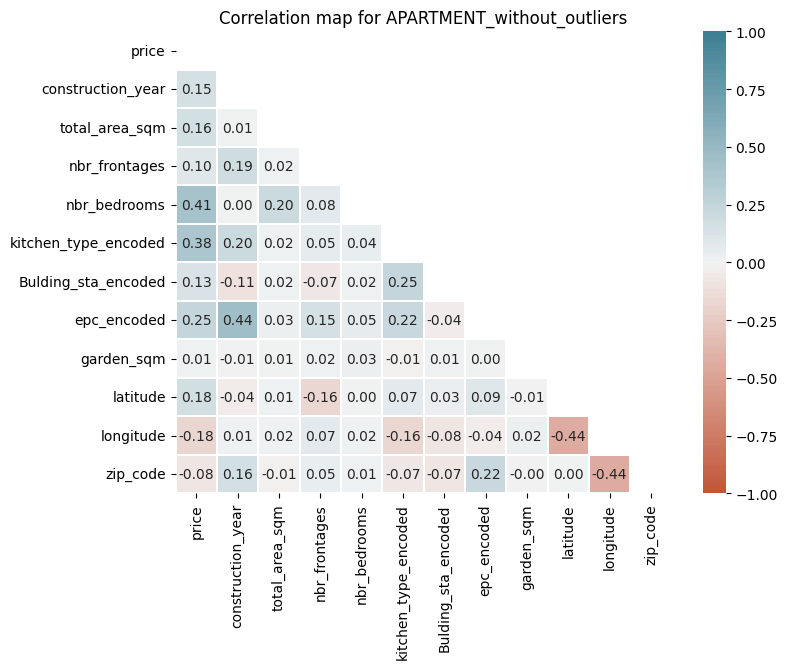

c:\Users\mgabi\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\mgabi\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Processing file: Houses_and_Apartments_combined_without_outliers.csv


C:\Users\mgabi\AppData\Local\Temp\ipykernel_30532\1627206934.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['construction_year'] = dataset['construction_year'].fillna(dataset['construction_year'].mode()[0]) # ---> best results appeared with the mode vlaue
C:\Users\mgabi\AppData\Local\Temp\ipykernel_30532\1627206934.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['nbr_bedrooms'] = dataset['nbr_bedrooms'].fillna(dataset['nbr_bedrooms'].mean()) # ---> best results appeared with the m

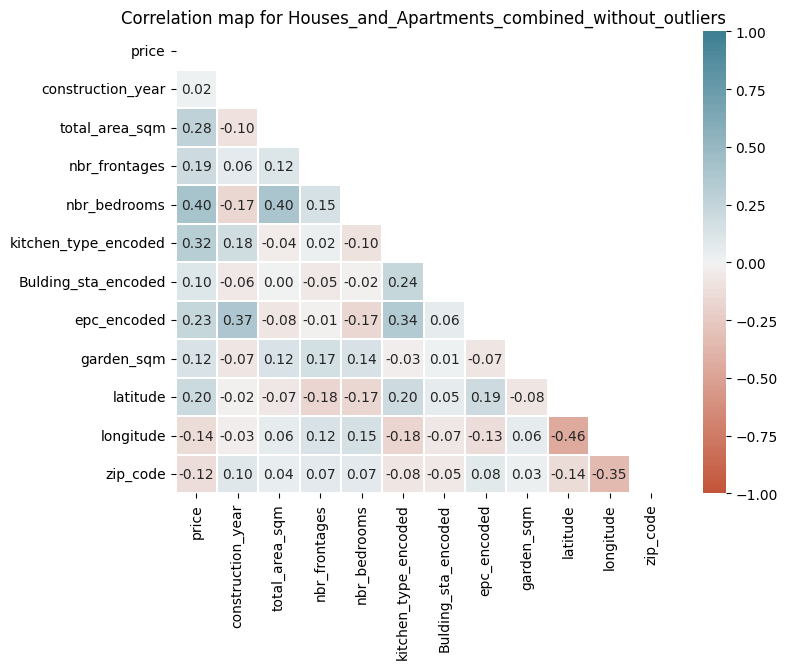

Processing file: HOUSE_without_outliers.csv


C:\Users\mgabi\AppData\Local\Temp\ipykernel_30532\1627206934.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['construction_year'] = dataset['construction_year'].fillna(dataset['construction_year'].mode()[0]) # ---> best results appeared with the mode vlaue
C:\Users\mgabi\AppData\Local\Temp\ipykernel_30532\1627206934.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['nbr_bedrooms'] = dataset['nbr_bedrooms'].fillna(dataset['nbr_bedrooms'].mean()) # ---> best results appeared with the m

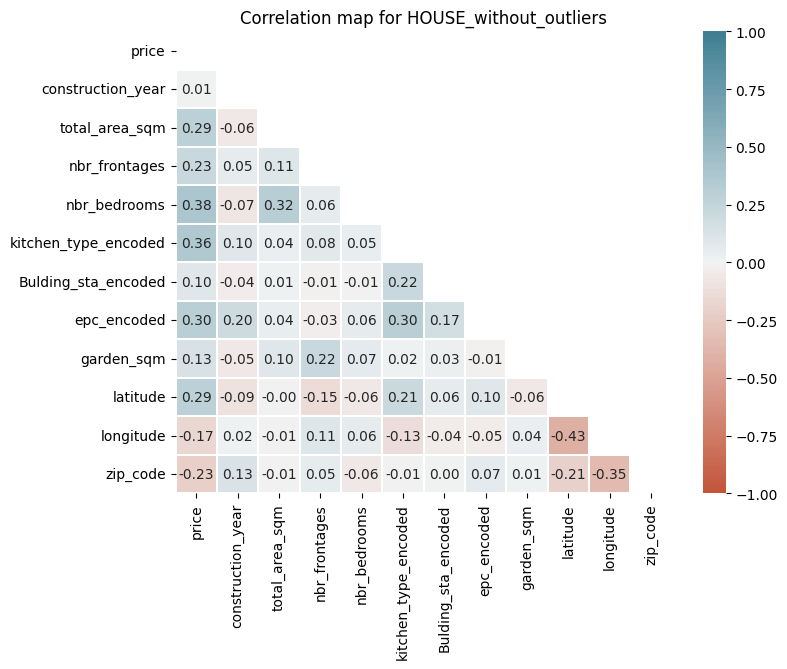

                                                                                File  \
RandomForest Regression                               APARTMENT_without_outliers.csv   
XGB Regression                                        APARTMENT_without_outliers.csv   
Hist Gradient Boosting Regression                     APARTMENT_without_outliers.csv   
RandomForest Regression            Houses_and_Apartments_combined_without_outlier...   
XGB Regression                     Houses_and_Apartments_combined_without_outlier...   
Hist Gradient Boosting Regression  Houses_and_Apartments_combined_without_outlier...   
RandomForest Regression                                   HOUSE_without_outliers.csv   
XGB Regression                                            HOUSE_without_outliers.csv   
Hist Gradient Boosting Regression                         HOUSE_without_outliers.csv   

                                                          Model name  \
RandomForest Regression                      Ra

In [4]:
# Processing each CSV file
directory = r"Results and Evaluation"
all_results = []

for file_name in os.listdir(directory):
    if file_name.endswith(".csv"):
        file_path = os.path.join(directory, file_name)
        print(f"Processing file: {file_name}")
        
        dataset = pd.read_csv(file_path)
        dataset, locality_encoded_columns = encoding(cleaning(dataset))   
        
        file_name_no_ext = os.path.splitext(file_name)[0]
        heat_map(dataset, title=f"Correlation map for {file_name_no_ext}", save_path=f"Results and Evaluation\Heat_maps\heatmap_{file_name_no_ext}.png")
       
        X = dataset[parameters + locality_encoded_columns]                   ##### The Encoded localities are called here. 
        y = dataset["price"]
         # Splitting the data 80% training and 20% testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
        
        models = {
            "RandomForest Regression": RandomForestRegressor(n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=20, bootstrap=True),
            "XGB Regression": XGBRegressor(n_estimators=900, subsample=0.8, min_child_weight=3, max_depth=8, learning_rate=0.05, gamma=0.2, colsample_bytree=0.36),
            "Hist Gradient Boosting Regression": HistGradientBoostingRegressor(min_samples_leaf=10, max_leaf_nodes=20, max_iter=500, max_depth=10, learning_rate=0.05, l2_regularization=0.0)
        }

        results_df = evaluate_models(X_train, X_test, y_train, y_test, models)
        results_df["File"] = file_name
        all_results.append(results_df)

final_results_df = pd.concat(all_results)
column_order = ["File", "Model name", "MAE", "RMSE", "R²", "Train Score", "Test Score"]
final_results_df = final_results_df[column_order]
print(final_results_df)

final_results_df.to_csv(r"Results and Evaluation\Evaluation_results\combined_model_evaluation_results.csv", index=False)